### PROJECT : AirBnB Seattle Reservation Prices Analysis

***Below are the questions that we will be answering through our analysis !!***

Can you describe the vibe of each Seattle neighborhood using listing descriptions?

What are the busiest times of the year to visit Seattle? By how much do prices spike?

Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

### Import all the libraries

In [46]:
## These libraries will be helpful for us in data handling and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Libraries that will be helpful for us in machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge

## evaluation metrics
from sklearn.metrics import r2_score,mean_squared_error

%matplotlib inline

### Load the datasets

In [2]:
listings = pd.read_csv('listings.csv')
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [3]:
calendar = pd.read_csv('calendar.csv')
calendar.head(2)

## Here date is the available date in listings and we will be mainly interesting in knowing the availability

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [4]:
reviews = pd.read_csv('reviews.csv')
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


### LEARNING ABOUT THE DATASETS

#### 1. LISTING DATASET 

#### A.Check if there are any null values in LISTINGS table

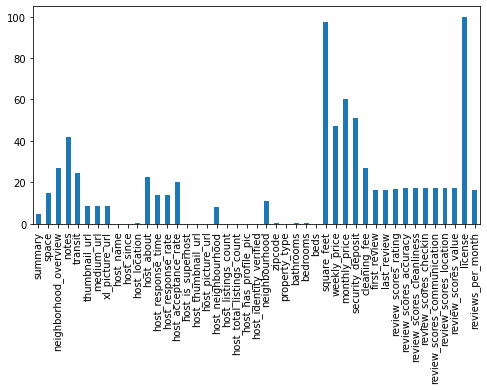

In [5]:
listings_null = listings.isnull().mean() *100
listings_null[listings_null>0].plot(kind='bar',figsize=((8,4)))

**From the above we can see that, columns like notes,square_feet,weekly_price, monthly_price, security_deposit, licencse has null values more than 40%. We can later on remove these from our dataset analysis**

#### B. Lets drop the columns that we won't be of very much use to us

In [7]:
cols_to_drop = ['listing_url','notes','square_feet','weekly_price','monthly_price','security_deposit','license','last_scraped','scrape_id',
         'summary','space','description','experiences_offered','neighborhood_overview','notes','transit','thumbnail_url',
         'xl_picture_url','medium_url','picture_url','host_url','host_name','host_about','host_thumbnail_url',
         'host_picture_url','city','state','market','country_code','country','latitude','longitude','smart_location',
         'has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped',
         'first_review','last_review','requires_license','jurisdiction_names','host_is_superhost','host_total_listings_count',
        'host_has_profile_pic','host_identity_verified','zipcode','neighbourhood','neighbourhood_cleansed']

In [8]:
listings.drop(cols_to_drop,axis=1,inplace=True)

In [9]:
print("Shape of the dataset after removing the dataset is:",listings.shape)

Shape of the dataset after removing the dataset is: (3818, 43)


**So,we see that we drop a lot of columns from the dataset.We dropped the features like url as they won't be much use for us. Also, while checking run the command listing[col].value_counts(), and if the values are same, that means we should drop it. Additionally we also drop the features that more than 40% of missing values in it.**

#### C. Check out the number of categorical variables and numerical features left after dropping the features

In [10]:
print("Number of features that are categorical:",len(listings.select_dtypes(include=['object']).columns))

Number of features that are categorical: 23


In [11]:
print("Number of features that are numerical:",len(listings.select_dtypes(include=['int','float']).columns))

Number of features that are numerical: 12


In [12]:
print("Shape of the dataset is:",listings.shape)

Shape of the dataset is: (3818, 43)


In [13]:
def cleaning_listing_dataset(dff):
    
    ## Here what we can do is that we can take only cities so that in future it would be easy for us to visualize also
    dff['cities'] = dff.host_location.str.split(',').str[0]
    dff.drop('host_location',axis=1,inplace=True)
    
    ## We can also realize that since most of the data is based out in  seattle, so we can pick only street name
    dff['street'] = dff.street.str.split(',').str[0]
    
    ## separate month, year and date from host_since
    dff['host_year'] = dff['host_since'].str.strip().str.split('-').str[0].astype(float)
    dff['host_month'] = dff['host_since'].str.strip().str.split('-').str[1].astype(float)
    dff['host_date'] = dff['host_since'].str.strip().str.split('-').str[2].astype(float)
    dff.drop('host_since',axis=1,inplace=True)
    
    ## remove $ from cleaning_fees, fees
    dff['cleaning_fee'] = dollar_removal('cleaning_fee')
    dff['price']  = dollar_removal('price')
    
    ## similarily we will remove the % sign
    dff['host_response_rate'] = percent_removal('host_response_rate')
    
    ### also convert extra people into 1/0
    dff['extra_people_cat'] =dff['extra_people'].apply(lambda x: extra_people_clean(x))
    
    dff.drop('host_acceptance_rate',axis=1,inplace=True) ## as almost all of them are 100%, and onlyt 1 is 0%
    
    ### now have to deal with ameneties and host_verifications
    convert_values_into_cols(dff,'host_verifications')
    dff.drop('host_verifications',axis=1,inplace=True)
    
    convert_values_into_cols(dff,'amenities')
    dff.drop('amenities',axis=1, inplace=True)
    
    ## we can also convert the host_response_rate to different buckets
    dff['host_response_bucket'] = pd.cut(x = dff['host_response_rate'],bins=5,labels = False, duplicates = 'drop')
    
    return dff

In [14]:
def extra_people_clean(val):
    
    if val == "$0.00":
        return 0
    else:
        return 1

In [15]:
def percent_removal(column):
    return listings[column].str.strip().str.replace('[%,]','').astype(float)

In [16]:
def dollar_removal(column):
    return listings[column].str.strip().str.replace('[$,]','').astype(float)

In [17]:
def convert_values_into_cols(df, col):
    values_count  = {}
    for i in df[col]:
        for j in i.replace("[",'').replace("'",'').replace("]",'').replace("{",'').replace("}",'').split(','):
            if j in values_count:
                values_count[j]+=1
            else:
                values_count[j] = 0
    
    ### we will only select the top 10 ameneties/host_verification modes,so lets sort them
    values_count = sorted(values_count.items(),key =  lambda x: x[1],reverse=True)[:10]
    
    # Now lets create a column for each row,so we will check whether each value is present in each row and we will
    # then replace it with 1, else we will replace it with 0
    for val in values_count:
        df[col+'_'+val[0]] = df.apply(lambda row: get_val(row,col, val[0]),axis=1)
    return 

In [18]:
def get_val(row,col, values):
    
    num = 0
    rows_values = row[col].replace("[",'').replace("'",'').replace("]",'').replace("{",'').replace("}",'').split(',')
    if values in  rows_values:
        num = 1
    else:
        num=0
    
    return num

In [19]:
cleaned_listings = cleaning_listing_dataset(listings)

In [20]:
cleaned_listings.head()

,id,name,host_id,host_response_time,host_response_rate,host_neighbourhood,host_listings_count,street,neighbourhood_group_cleansed,is_location_exact,...,amenities_Heating,amenities_Kitchen,"amenities_""Smoke Detector""",amenities_Essentials,amenities_Dryer,amenities_Washer,amenities_Internet,amenities_Shampoo,amenities_TV,host_response_bucket
0,241032,Stylish Queen Anne Apartment,956883,within a few hours,96.0,Queen Anne,3.0,Gilman Dr W,Queen Anne,t,...,1,1,0,0,1,1,1,0,1,4.0
1,953595,Bright & Airy Queen Anne Apartment,5177328,within an hour,98.0,Queen Anne,6.0,7th Avenue West,Queen Anne,t,...,1,1,1,1,1,1,1,0,1,4.0
2,3308979,New Modern House-Amazing water view,16708587,within a few hours,67.0,Queen Anne,2.0,West Lee Street,Queen Anne,t,...,1,1,1,1,1,1,1,1,1,3.0
3,7421966,Queen Anne Chateau,9851441,NaN,NaN,Queen Anne,1.0,8th Avenue West,Queen Anne,t,...,1,1,1,1,1,1,1,1,0,NaN
4,278830,Charming craftsman 3 bdm house,1452570,within an hour,100.0,Queen Anne,2.0,14th Ave W,Queen Anne,t,...,1,1,1,1,0,0,1,1,1,4.0


### 2. Calendar dataset

#### A. Check if there are any null values in CALENDER table

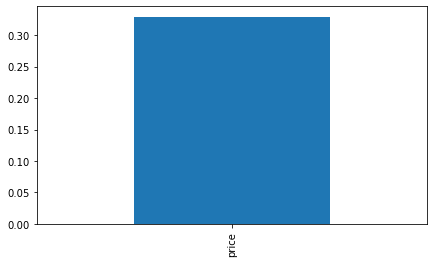

In [21]:
calender_null = calendar.isnull().mean()
calender_null[calender_null >0].plot(kind='bar',figsize=(7,4))

**Here we can see that the price column has around 32% of values as missing, we will drop these, as null values are for those where there is no availability.**

In [22]:
def calendar_cleaning(df):
    
    df.dropna(subset = ['price'],inplace=True) # we do it because for non-availabilty we dont have any price
    df.drop('available',axis=1, inplace=True)
    
    df['price'] = df['price'].str.strip().str.replace('[$,]','').astype('float')
    df['available_year']  = df['date'].str.split('-').str[0].astype(int)
    df['available_month'] = df['date'].str.split('-').str[1].astype(int)
    df['available_date'] = df['date'].str.split('-').str[2].astype(int)
    ### Now we can also drop the date column, as we dont need it now
    df.drop('date',axis=1,inplace=True)
    
    return df

In [23]:
cleaned_calendar = calendar_cleaning(calendar)

In [24]:
cleaned_calendar.head()

,listing_id,price,available_year,available_month,available_date
0,241032,85.0,2016,1,4
1,241032,85.0,2016,1,5
9,241032,85.0,2016,1,13
10,241032,85.0,2016,1,14
14,241032,85.0,2016,1,18


### 3. At this point we have the cleaned datasets, now lets merge both the datasets, and also, we need to fill the missing values

In [25]:
def merge_datasets(df1,df2):
    df = pd.merge(df1,df2,left_on ='listing_id', right_on = "id")
    
    ### here we can see that all of the values related to reviews_* are numerical and contains null values
    reviews_cols =['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
                   'review_scores_communication', 'review_scores_location','review_scores_value', 'reviews_per_month']
    
    for cols in reviews_cols:
        df[cols].fillna(value = df[cols].mean(), inplace=True)
        
    # Then null values in the below feature are replaced with there mode values
    df['beds'].fillna(df['beds'].mode()[0], inplace=True)
    df['bathrooms'].fillna(df['bathrooms'].mode()[0], inplace=True)
    df['bedrooms'].fillna(df['bedrooms'].mode()[0], inplace=True)
    df['property_type'].fillna(df['property_type'].mode()[0], inplace=True)
    df['cities'].fillna(df['cities'].mode()[0], inplace=True)
    df['host_response_time'].fillna(df['host_response_time'].mode()[0], inplace=True)
    df['host_neighbourhood'].fillna(df['host_neighbourhood'].mode()[0], inplace=True)
    df['cleaning_fee'].fillna(df['cleaning_fee'].mode()[0], inplace=True)
    df['host_response_bucket'].fillna(df['host_response_bucket'].mode()[0], inplace=True)
    
    # Then null values in the below feature are replaced with there mean values
    df['host_response_rate'].fillna(df['host_response_rate'].mean(),inplace=True)
    df['host_year'].fillna(df['host_year'].mean(), inplace=True)
    df['host_month'].fillna(df['host_month'].mean(), inplace=True)
    df['host_date'].fillna(df['host_date'].mean(), inplace=True)
    
    df.dropna(inplace=True)
    
    return df

In [26]:
df = merge_datasets(cleaned_calendar, cleaned_listings)

In [27]:
df.drop(['price_y','name'],axis=1, inplace=True)
## here we are dropping price_y, as it came twice and also name as it is the name of the property

**This this point all the data has been merged.Now lets solve the problems assigned with this dataset**

### 1. What are the busiest times of the year to visit Seattle? By how much do prices spike?

#### Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

**To solve the part-a) what we can do is year-wise, we can take check the trend of months and the listings **
**For part-b) what we can check the months vs price and see the price spikes**

#### PART-A

In [28]:
df['available_year'].value_counts()

2016    928752
2017      5698
Name: available_year, dtype: int64

In [29]:
df_2016 =  df[df['available_year']==2016]

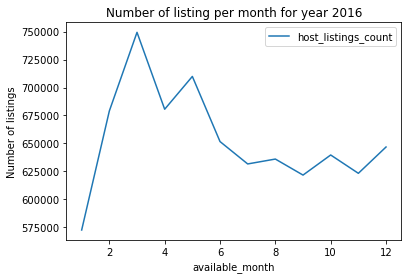

In [30]:
df_2016.groupby('available_month').agg({'host_listings_count':'sum'}).plot()
plt.ylabel('Number of listings')
plt.title('Number of listing per month for year 2016');

**Here one thing to note is that we are mainly interested in Calendar availability of months, date & year, as these are the dates on which the particular listing is available, whereas the host dates are the dates when host can offer the listings but not the availabilty**

**In the above we can see that the busiest time of the year in Seattle is March means summer and we can see some increasing trend in december means winter, so it tells us that summer and winter are the busiest time in seattle**

#### PART-B

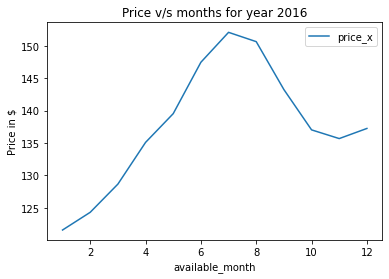

In [31]:
df_2016.groupby('available_month').agg({'price_x':'mean'}).plot()
plt.ylabel('Price in $')
plt.title('Price v/s months for year 2016');

**Here we can notice that, prices are more in months of June-July-aug-sep, it may be due to the fact that there are less listings available when we compare it with the above graph**

### 2. Can you describe the vibe of each Seattle neighborhood using listing descriptions?

**For this, first of all we need to group by them on the basis of months and neighbourhood**

In [32]:
neighbourhood_data = df.groupby(['available_month','neighbourhood_group_cleansed']).mean()['price_x'].reset_index()
neighbourhood_data.head()

,available_month,neighbourhood_group_cleansed,price_x
0,1,Ballard,108.986406
1,1,Beacon Hill,97.777725
2,1,Capitol Hill,123.823421
3,1,Cascade,139.289689
4,1,Central Area,120.513238


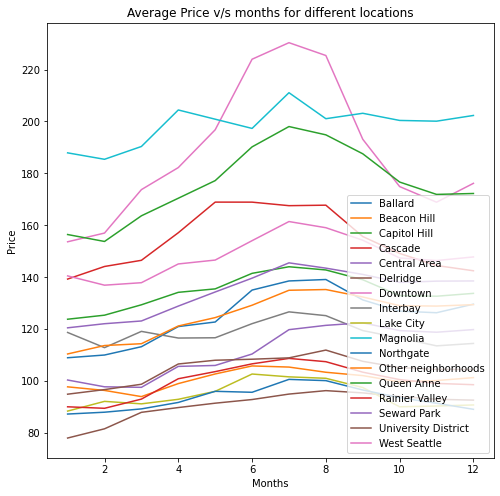

In [33]:
unique_neighbourhood = neighbourhood_data.neighbourhood_group_cleansed.unique()
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
for i in unique_neighbourhood:
    ax.plot(neighbourhood_data[neighbourhood_data['neighbourhood_group_cleansed'] ==i]['available_month'],
           neighbourhood_data[neighbourhood_data['neighbourhood_group_cleansed'] ==i]['price_x'],label=i)

ax.legend(loc='lower right')
ax.set(title = 'Average Price v/s months for different locations', xlabel = 'Months', ylabel='Price');

**In the above we can see different prices for different locations**

### NOW LETS DO MACHINE LEARNING OVER IT

**1. Lets delete some of the features that are of no use now**

In [34]:
df.drop(['listing_id','id','host_id'],axis=1,inplace=True)

In [35]:
# In street column, we can see there are lot of unique values which are very difficult to convert to categorical
# so better to drop this as well

df.drop('street',axis=1,inplace=True)

**2. Now convert all the categorical features with dummy variables**

In [36]:
cat_features = df.select_dtypes(include = ['object']).columns
cat_features

### These are all of the categorical features that are present in dataframe

Index(['host_response_time', 'host_neighbourhood',
       'neighbourhood_group_cleansed', 'is_location_exact', 'property_type',
       'room_type', 'bed_type', 'extra_people', 'calendar_updated',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'cities'],
      dtype='object')

In [37]:
for col in cat_features:
    
    dummies = pd.get_dummies(df[col],prefix=col, prefix_sep='_')
    df = pd.concat((df.drop(col,axis=1),dummies),axis=1)

**3. Now split the dataset**

In [38]:
X = df.drop('price_x',axis=1)
y = df['price_x']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
print("Shape of X_train is: ",X_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (654115, 391)
Shape of X_test is:  (280335, 391)
Shape of y_train is:  (654115,)
Shape of y_test is:  (280335,)


**Lets scale our dataset as well**

In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

***Since this is a supervised and an regression problem, we will be using different regression techniques like: Decision tree regressor, Ridge Regression, XGBoost regressor, random forest regressor and see which one gives us the best r2 (r-squared) value and we can use that model for to find out best features usuing feature importance***

In [43]:
for algorithm in ['DecisionTreeRegressor','RandomForestRegressor','Ridge','xgb']:
    if algorithm == 'DecisionTreeRegressor' : model = DecisionTreeRegressor();
    elif algorithm == 'RandomForestRegressor': model  = RandomForestRegressor();
    elif algorithm == 'Ridge': model = Ridge();
    elif algorithm == "xgb": model = xgb.XGBRegressor();
    
    
    model.fit(X_train_sc, y_train)
    pred = model.predict(X_test_sc)
    print(f"r2_score for {algorithm} is:", r2_score(y_test,pred))

r2_score for DecisionTreeRegressor is: 0.9785513034251158
r2_score for RandomForestRegressor is: 0.9861614354737575
r2_score for Ridge is: 0.7080358784906668
r2_score for xgb is: 0.9441764384022868


**From the above we can see that Random Forest Regressor has the highest r-squared value, so we can use this model to find out the feature importance**

In [45]:
model = RandomForestRegressor()
model.fit(X_train_sc,y_train)

preds = model.predict(X_test_sc)
print("R-squared value for random forest regressor is:", r2_score(y_test, preds))

R-squared value for random forest regressor is: 0.986218325495173


**Lets find out which all are the importance features using the feature importance metric**

In [77]:
feature_imp = sorted(zip(df.columns, model.feature_importances_), key = lambda x: x[-1], reverse=True)

In [80]:
df_new = pd.DataFrame(feature_imp, columns = ['features','scores'])

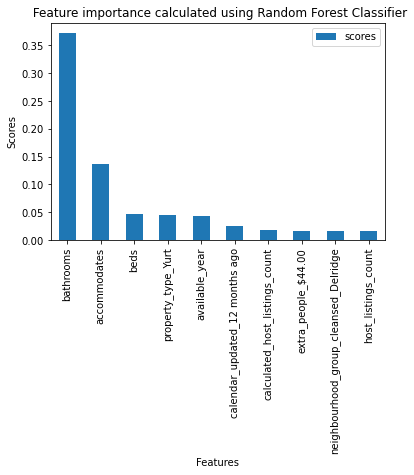

In [94]:
x = df_new[:10]
x.set_index('features').plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title(' Feature importance calculated using Random Forest Classifier');

**From the above we can see that some of the best features are: Bathrooms, how many person they can accomodate, beds, property type, whether the calendar is updated or not?**

**$$Thank you!!$$**